# 0. Selecting 20 emoticons 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
all_tweets = pd.read_csv("data/emojis.csv")
all_tweets.head()

,text,emoji
0,@ATLHawks: Chance The Rapper or Kent Bazemore?...,🤔
1,"@nice_aju: Yup we love you, you're so precious...",💙
2,Fav Sing Me to Sleep by Alan Walker,💛
3,@AshBenzo: Wife From The Real-Life 'Fault In O...,💔
4,Why am I up so late,😔


In [3]:
# !pip install emot

import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

In [4]:
unique_emoji = all_tweets.emoji.unique()
print(len(unique_emoji))

989


In [5]:
emoji_counts = all_tweets['emoji'].value_counts().head(20)
emoji_counts = emoji_counts.to_frame()

In [6]:
emoji_list = np.array(emoji_counts.index)

df = all_tweets.loc[all_tweets['emoji'].isin(emoji_list)]

In [7]:
pattern = r'(http://[^"\s]+)|(@\w+)|(:)|([^\w\d\s\.\?\!])'

In [8]:
df.loc[:, "text"] = df.text.str.replace(pattern, "").values

C:\Users\subon\Desktop\anaconda\envs\test\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


# 1. Vectorization

In [9]:
max_string = max(df['text'], key=lambda t:len(t))
print(max_string)
max_string_len = len(re.split(r'[\s+^\.]', max_string))
print(max_string_len)

Have a better relationship with Ollies mum than I do Ollie.Coming into the salon for a quick natter while Ollie stand there hands over face
26


### max_pad_sequence length: 26

In [10]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_emojis, test_emojis = train_test_split(df['text'], df['emoji'], stratify = df['emoji'],
                                                                             random_state = 3011) # for consistency

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[official documentation](https://keras.io/preprocessing/text/)

In [12]:
tokenizer = Tokenizer(oov_token = 'OOV')
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
print(len(word_index))

84107


In [13]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding = 'post', maxlen = max_string_len)
print(train_padded[0])
print(train_padded.shape)

[ 40  42   5 251  12  26 220   4 100  18 663 971   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]
(321638, 26)


In [14]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding = 'post', maxlen = max_string_len)
print(test_padded[0])
print(test_padded.shape)

[  36 2030  630    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
(107213, 26)


In [15]:
actual_emoji = df['emoji'].value_counts().index.values
print(actual_emoji)

['😂' '❤' '😍' '😭' '😊' '🙄' '😩' '🔥' '🤔' '💕' '💯' '😘' '💀' '✨' '🙃' '👀' '😒' '☺'
 '😢' '😳']


In [16]:
label_emoji_mapping = dict([(label, emoji) for label, emoji in zip(range(20), actual_emoji)])
emoji_label_mapping = dict([(emoji, label) for label, emoji in label_emoji_mapping.items()])
print(label_emoji_mapping)
print(emoji_label_mapping)

{0: '😂', 1: '❤', 2: '😍', 3: '😭', 4: '😊', 5: '🙄', 6: '😩', 7: '🔥', 8: '🤔', 9: '💕', 10: '💯', 11: '😘', 12: '💀', 13: '✨', 14: '🙃', 15: '👀', 16: '😒', 17: '☺', 18: '😢', 19: '😳'}
{'😂': 0, '❤': 1, '😍': 2, '😭': 3, '😊': 4, '🙄': 5, '😩': 6, '🔥': 7, '🤔': 8, '💕': 9, '💯': 10, '😘': 11, '💀': 12, '✨': 13, '🙃': 14, '👀': 15, '😒': 16, '☺': 17, '😢': 18, '😳': 19}


In [17]:
y_train, y_test = train_emojis.replace(emoji_label_mapping), test_emojis.replace(emoji_label_mapping)

print(pd.Series(y_train).head())
print(pd.Series(y_test).head())

94558      2
610615     2
287420     0
319632     0
665696    16
Name: emoji, dtype: int64
147070     3
610579    18
589621     1
519277     0
452605     3
Name: emoji, dtype: int64


In [18]:
from tensorflow.keras.utils import to_categorical

y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

print(train_padded.shape, test_padded.shape)
print(y_train_onehot.shape, y_test_onehot.shape)

(321638, 26) (107213, 26)
(321638, 20) (107213, 20)


### looks like we are prepared ...

# 2. Exploiting CNN model
[reference link](http://ceur-ws.org/Vol-2244/paper_11.pdf)

In [19]:
from tensorflow.keras import models, layers

vocab_size = len(word_index) + 1
embedding_dim = 200

model = models.Sequential()
model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim,
                          embeddings_regularizer = 'l2', input_length = 26, mask_zero = True, trainable = True))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(filters = 512, kernel_size = 5, activation = 'relu',
                       padding = 'same', kernel_regularizer = 'l2'))
model.add(layers.MaxPool1D(5))
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(20, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 200)           16821600  
_________________________________________________________________
dropout (Dropout)            (None, 26, 200)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 512)           512512    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 512)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                5

In [20]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings('ignore')


callback_list = [ModelCheckpoint(filepath = 'cnn_model.h5', monitor = 'loss',
                                                    save_best_only = True),
                 EarlyStopping(patience = 5)]

history = model.fit(train_padded, y_train_onehot, batch_size = 2048, epochs = 10, callbacks = callback_list,
                   validation_data = (test_padded, y_test_onehot))

Train on 321638 samples, validate on 107213 samples
Epoch 1/10
321638/321638 [==============================] - 1709s 5ms/sample - loss: 15.2617 - acc: 0.2897 - val_loss: 2.5437 - val_acc: 0.2911
Epoch 2/10
321638/321638 [==============================] - 1771s 6ms/sample - loss: 2.5446 - acc: 0.2911 - val_loss: 2.5448 - val_acc: 0.2911
Epoch 3/10
321638/321638 [==============================] - 1743s 5ms/sample - loss: 2.5423 - acc: 0.2911 - val_loss: 2.5417 - val_acc: 0.2911
Epoch 4/10
321638/321638 [==============================] - 1741s 5ms/sample - loss: 2.5399 - acc: 0.2911 - val_loss: 2.5388 - val_acc: 0.2911
Epoch 5/10
321638/321638 [==============================] - 1746s 5ms/sample - loss: 2.5258 - acc: 0.3028 - val_loss: 2.5116 - val_acc: 0.3150
Epoch 6/10
321638/321638 [==============================] - 1766s 5ms/sample - loss: 2.5011 - acc: 0.3206 - val_loss: 2.4913 - val_acc: 0.3288
Epoch 7/10
321638/321638 [==============================] - 1753s 5ms/sample - loss: 2.48

In [25]:
model.load_weights('cnn_model.h5')
model.evaluate(test_padded, y_test_onehot)

107213/107213 [==============================] - 429s 4ms/sample - loss: 2.4599 - acc: 0.3417


[2.459889987176999, 0.34166566]

In [26]:
model.save_weights('cnn_weights.h5')
model.save('cnn_model.h5')

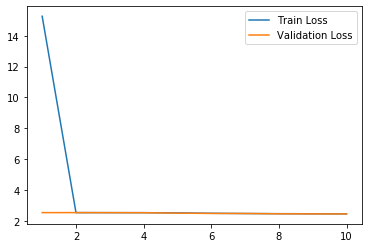

In [44]:
import matplotlib.pyplot as plt
epochs = np.arange(1, 11)
plt.plot(epochs, history.history['loss'], label = 'Train Loss')
plt.plot(epochs, history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.savefig('cnn_loss.png')
plt.show()

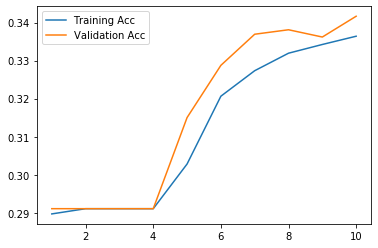

In [45]:
plt.plot(epochs, history.history['acc'], label = 'Training Acc')
plt.plot(epochs, history.history['val_acc'], label = 'Validation Acc')
plt.legend()
plt.savefig('cnn_acc.png')
plt.show()

In [46]:
class getXY():
    def __init__(self):
        pass
    
    def get_train_set(self):
        return train_padded, y_train_onehot
    
    def get_test_set(self):
        return test_padded, y_test_onehot


import pickle

with open('getXY.pickle', 'wb') as f:
    pickle.dump(getXY, f)
    
with open('getXY.pickle', 'rb') as f:
    test = pickle.load(f)

In [47]:
x, y = test().get_train_set()

In [48]:
np.all(x == train_padded) and np.all(y == y_train_onehot)

True